In [ ]:
# !pip install matplotlib
# !pip install seaborn

**타이타닉 생존자 ML 예측 구현**
- 데이터 전처리
- 모델 학습 및 검증/예측/평가
    - 결정트리, 랜덤포레스트, 로지스틱 회귀 학습 비교
    - cross_val_score(), GridSearchCV() 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

titanic_df = pd.read_csv('../1.Basic/titanic/train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


* Passengerid: 탑승자 데이터 일련번호
* survived: 생존 여부, 0 = 사망, 1 = 생존
* Pclass: 티켓의 선실 등급, 1 = 일등석, 2 = 이등석, 3 = 삼등석
* sex: 탑승자 성별
* name: 탑승자 이름
* Age: 탑승자 나이
* sibsp: 같이 탑승한 형제자매 또는 배우자 인원수
* parch: 같이 탑승한 부모님 또는 어린이 인원수
* ticket: 티켓 번호
* fare: 요금
* cabin: 선실 번호
* embarked: 중간 정착 항구 C = Cherbourg, Q = Queenstown, S = Southampton

In [2]:
print('\n ### train 데이터 정보 ###  \n')
print(titanic_df.info())


 ### train 데이터 정보 ###  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


**NULL 컬럼들에 대한 처리**

In [3]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(),inplace=True)
titanic_df['Cabin'].fillna('N',inplace=True)
titanic_df['Embarked'].fillna('N',inplace=True)

print('데이터 세트 Null 값 갯수 ',titanic_df.isnull().sum().sum())

데이터 세트 Null 값 갯수  0


In [4]:
print('데이터 세트 Null 값 갯수 ',titanic_df.isnull().sum())

데이터 세트 Null 값 갯수  PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


**값 분포 확인, value_counts()**

In [5]:
print(' Sex 값 분포 :\n',titanic_df['Sex'].value_counts())
print('\n Cabin 값 분포 :\n',titanic_df['Cabin'].value_counts())
print('\n Embarked 값 분포 :\n',titanic_df['Embarked'].value_counts())

 Sex 값 분포 :
 male      577
female    314
Name: Sex, dtype: int64

 Cabin 값 분포 :
 N              687
C23 C25 C27      4
G6               4
B96 B98          4
F33              3
              ... 
E46              1
C85              1
C30              1
B4               1
D6               1
Name: Cabin, Length: 148, dtype: int64

 Embarked 값 분포 :
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


In [6]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))
titanic_df['Cabin'].value_counts()

0    N
1    C
2    N
Name: Cabin, dtype: object


N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

**데이터 분포 확인, groupby()**

In [7]:
titanic_df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

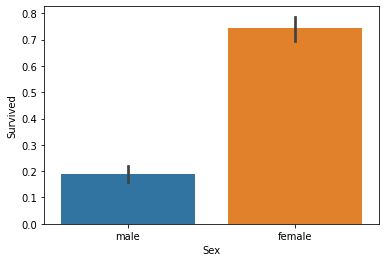

In [8]:
sns.barplot(x='Sex', y = 'Survived', data=titanic_df)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

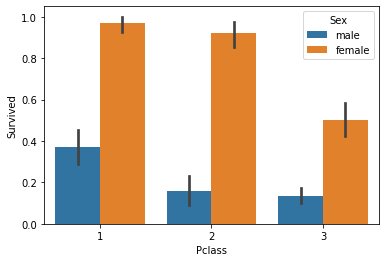

In [9]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

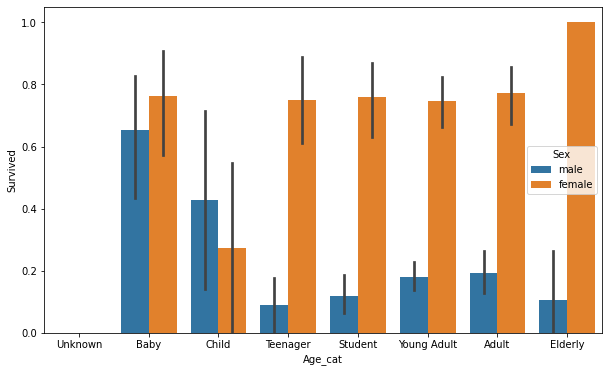

In [10]:
# 입력 age에 따라 구분값을 반환하는 함수 설정. DataFrame의 apply lambda식에 사용. 
def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else : cat = 'Elderly'
    
    return cat

# 막대그래프의 크기 figure를 더 크게 설정 
plt.figure(figsize=(10,6))

#X축의 값을 순차적으로 표시하기 위한 설정 
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category( ) 함수를 반환값으로 지정. 
# get_category(X)는 입력값으로 'Age' 컬럼값을 받아서 해당하는 cat 반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x='Age_cat', y = 'Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True)

**데이터 전처리**
- null 처리
- 인코딩

In [11]:
from sklearn import preprocessing

def encode_features(dataDF):
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


In [12]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df


In [13]:
# 원본 데이터를 재로딩 하고, feature데이터 셋과 Label 데이터 셋 추출. 
titanic_df = pd.read_csv('../1.Basic/titanic/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived',axis=1)

X_titanic_df = transform_features(X_titanic_df)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, \
                                                  test_size=0.2, random_state=11)


**모델**
- DecisionTree
- RandomForest
- LogisticRegression

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train , y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train , y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train , y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))


DecisionTreeClassifier 정확도: 0.7877
RandomForestClassifier 정확도:0.8547
LogisticRegression 정확도: 0.8492


/Users/imsoyoung/opt/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**결과**

성능평가방법|Model|평균정확도
--|--|--
KFold|dt_clf (DecisionTree)|0.7823
|rf_clf (RandomForest)|0.8148
|lr_clf (LogisticRegression)| 0.7845
cross_val|dt_clf (DecisionTree)| 0.7879
|rf_clf (RandomForest)|0.8137
|lr_clf (LogisticRegression)| 0.7845
GridSearchCV|dt_clf (DecisionTree)| 0.7992
|rf_clf (RandomForest)|0.8146
|lr_clf (LogisticRegression)| 

***
cf. Hyperparameter
- DecisionTree : n_estimators, max_depth, min_samples_split, max_features
- RandomForest : n_estimators
- LogisticRegression : C, solver ... 


In [22]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
    # 폴드 세트를 5개인 KFold객체를 생성, 폴드 수만큼 예측결과 저장을 위한  리스트 객체 생성.
    kfold = KFold(n_splits=folds)
    scores = []
    
    # KFold 교차 검증 수행. 
    for iter_count , (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        
        # Classifier 학습, 예측, 정확도 계산 
        clf.fit(X_train, y_train) 
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))     
    
    # 5개 fold에서의 평균 정확도 계산. 
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score)) 
# exec_kfold 호출
exec_kfold(rf_clf , folds=5) 


교차 검증 0 정확도: 0.7933
교차 검증 1 정확도: 0.8090
교차 검증 2 정확도: 0.8371
교차 검증 3 정확도: 0.7753
교차 검증 4 정확도: 0.8596
평균 정확도: 0.8148


In [25]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_clf, X_titanic_df , y_titanic_df , cv=5)
for iter_count,accuracy in enumerate(scores):
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))

print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검증 0 정확도: 0.7933
교차 검증 1 정확도: 0.7978
교차 검증 2 정확도: 0.8483
교차 검증 3 정확도: 0.7640
교차 검증 4 정확도: 0.8652
평균 정확도: 0.8137


In [27]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10],
             'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8]}

grid_dclf = GridSearchCV(rf_clf , param_grid=parameters , scoring='accuracy' , cv=5)
grid_dclf.fit(X_train , y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :',grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test , dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))


GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.8146
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8827
